<a href="https://colab.research.google.com/github/descartesmbogning/topic-modeling-lda/blob/main/Patent_TopicModeling_23102023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

import spacy
import codecs
import re
from wordcloud import STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from nltk.stem.porter import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/patent-phage-therapy-lens-23102023-tiab.csv')
pd.set_option('display.max_columns', None)
print(len(df))
df.head()

2365


,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
0,1,RU,C2,RU 2214829 C2,069-390-611-717-343,2003-10-27,2003,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED
1,2,JP,A,JP 2016104011 A,114-759-028-882-736,2016-06-09,2016,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE
2,3,AU,A1,AU 2015/255318 A1,094-982-928-461-863,2015-12-03,2015,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE
3,4,US,A1,US 2016/0022747 A1,167-908-891-122-112,2016-01-28,2016,US 201514852112 A,2015-09-11,US 201514852112 A;;US 201113148009 A;;PT 20100...,2009-02-06,"Antibacterial Phage, Phage Peptides and Method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,https://lens.org/167-908-891-122-112,Patent Application,yes,0,1,42,45,816,A61K38/00;;A61K45/06;;C07K14/005;;C12N7/00;;C1...,A61K35/76;;A61K9/00;;C12N7/00,NaN,0,0,NaN,NaN,NaN,ACTIVE
4,5,AU,A1,AU 2017/204331 A1,112-018-476-081-94X,2017-07-13,2017,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED


In [ ]:
## Convert 'Publication Year' to integers
df['Publication Year'] = df['Publication Year'].astype(int)

# Filter based on 'Publication Year' column
#df = df[df['Publication Year'] >= 2003]
len(df)

2365

In [ ]:
df = df[(~pd.isnull(df['Abstract'])) & (~pd.isnull(df['Title']))]
len(df)

2348

In [ ]:
df = df.set_index(['Lens ID','Publication Year'])
df

,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
069-390-611-717-343,2003,1,RU,C2,RU 2214829 C2,2003-10-27,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED
114-759-028-882-736,2016,2,JP,A,JP 2016104011 A,2016-06-09,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE
094-982-928-461-863,2015,3,AU,A1,AU 2015/255318 A1,2015-12-03,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE
167-908-891-122-112,2016,4,US,A1,US 2016/0022747 A1,2016-01-28,US 201514852112 A,2015-09-11,US 201514852112 A;;US 201113148009 A;;PT 20100...,2009-02-06,"Antibacterial Phage, Phage Peptides and Method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,https://lens.org/167-908-891-122-112,Patent Application,yes,0,1,42,45,816,A61K38/00;;A61K45/06;;C07K14/005;;C12N7/00;;C1...,A61K35/76;;A61K9/00;;C12N7/00,NaN,0,0,NaN,NaN,NaN,ACTIVE
112-018-476-081-94X,2017,5,AU,A1,AU 2017/204331 A1,2017-07-13,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150-422-589-010-681,1969,2361,GB,A,GB 1165745 A,1969-10-01,GB 3886866 A,1966-08-31,US 48872465 A,1965-09-20,Novel Dinucleoside Phosphates,"1,165,745. Dinucleoside phosphates. UPJOHN CO....",UPJOHN CO,NaN,NaN,https://lens.org/150-422-589-010-681,Granted Patent,no,0,0,7,7,0,C07H19/14;;C07H19/14;;Y02P20/55;;Y02P20/55;;Y1...,C07H19/14,C2A A1B -;;C2A A1C2C -;;C2A ...,0,0,NaN,NaN,NaN,EXPIRED
058-819-734-343-222,1969,2362,GB,A,GB 1165354 A,1969-09-24,GB 3887066 A,1966-08-31,US 48879965 A,1965-09-20,Novel Dinucleoside Phosphates,"1,165,354. Dinucleoside phosphates. UPJOHN CO....",UPJOHN CO,NaN,NaN,https://lens.org/058-819-734-343-222,Granted Patent,no,0,0,7,7,0,C07H19/04;;C07H19/044;;C07H19/207;;C08F2/00;;C...,C07H19/04;;C07H19/044;;C07H19/207;;C08F2/00;;C...,C2A A1B -;;C2A A1C2C -;;C2C ...,0,0,NaN,NaN,NaN,EXPI

In [ ]:
data = [str(df['Title'][i])+str(df['Abstract'][i]) for i in df.index] #Title and Abstract
len(data)

2348

In [ ]:
#data

In [ ]:
!python -m spacy download en_core_web_md

2023-11-13 03:00:18.140276: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 03:00:18.140345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 03:00:18.140389: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 03:00:20.024558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
s = set(STOPWORDS)
sw = stopwords.words('english')
sw += s
sw.append ('amp')

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloads
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize your stopwords set with wordcloud's stopwords
s = set(STOPWORDS)

# Get stopwords for all languages in NLTK
languages = stopwords.fileids()
for language in languages:
    s.update(stopwords.words(language))

# Add any additional stopwords if needed
s.add('amp')

# If you really need the resulting stopwords as a list:
sw = list(s)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Read the texts and remove the stopwords :
#Build the text list:
txt = []
idx = []
t1 = ''
t2 = []
for i in range(len(data)):
        t1 = str(data[i]).lower()
 #       t1 = re.sub ('#','',t1)
        #t1 = re.sub ('.','',t1)
 #       t1 = re.sub (',','',t1)
 #       t1 = re.sub ("'",'',t1)
#        t1 = t1.replace('.','')
        t2 = t1.split()
        t1 = ''
        for item2 in t2:
            if item2 not in sw:
                t1 += item2
                t1 += ' '
        if t1[:-1] not in txt and t1[:-1] != '':
            txt.append (t1[:-1])
            idx.append (i)
len (txt)

2309

In [ ]:
#pip install --upgrade ipykernel

In [ ]:
idx

[0,
 1,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187

In [ ]:
#txt

In [ ]:
print(type(txt))

<class 'list'>


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Assume df is your original DataFrame
# Remove rows where either 'Abstract' or 'Title' is null
df = df.dropna(subset=['Abstract', 'Title'])

# Generate the data list combining 'Title' and 'Abstract'
data = [str(df['Title'].iloc[i]) + str(df['Abstract'].iloc[i]) for i in range(len(df))]

## Download necessary NLTK resources
#nltk.download('wordnet')
#nltk.download('stopwords')

## Generate a list of stopwords
#s = set(STOPWORDS)
#sw = set(stopwords.words('english'))
#sw |= s
#sw.add('amp')

# Initialize a list to store cleaned texts
cleaned_texts = []

# Text preprocessing
for text in data:
    words = text.lower().split()
    cleaned_words = [word for word in words if word not in sw]
    cleaned_text = ' '.join(cleaned_words)
    cleaned_texts.append(cleaned_text)

# Add the cleaned texts back to the original DataFrame
df['Cleaned_Text'] = cleaned_texts
len(df)

2348

In [ ]:
# Drop rows where 'Cleaned_Text' is null
df_filtered = df.dropna(subset=['Cleaned_Text'])

# Keep only the rows with unique 'Cleaned_Text'
df_filtered = df_filtered.drop_duplicates(subset=['Cleaned_Text'])
df_filtered

,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Cleaned_Text
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
069-390-611-717-343,2003,1,RU,C2,RU 2214829 C2,2003-10-27,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED,method tuberculosis phagotherapyfield: medicin...
114-759-028-882-736,2016,2,JP,A,JP 2016104011 A,2016-06-09,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE,"antibacterial phages, phage peptides methods t..."
094-982-928-461-863,2015,3,AU,A1,AU 2015/255318 A1,2015-12-03,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE,"antibacterial phage, phage peptides methods th..."
112-018-476-081-94X,2017,5,AU,A1,AU 2017/204331 A1,2017-07-13,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED,"antibacterial phage, phage peptides methods th..."
091-234-230-295-135,2020,6,CN,A,CN 110691603 A,2020-01-14,CN 201780084644 A,2017-12-04,US 201662430113 P;;PT 2017050028 W,2016-12-05,BACTERIOPHAGE COMPOSITIONS COMPRISING RESPIRAT...,The present invention is directed to the field...,TECHNOPHAGE INVESTIG E DESENVOLVIMENTO EM BIOT...,CORTE-REAL SOFIA VALKER;;COSTA GARCIA MIGUEL A...,NaN,https://lens.org/091-234-230-295-135,Patent Application,no,2,0,17,17,0,A61K35/76;;C12N2795/00011;;C12N2795/00021;;C12...,A61K35/76;;A01N63/40;;A61P31/04;;C12N7/00;;C12...,NaN,2,2,012-547-311-502-556;;041-469-997-710-624,10.1128/jb.188.3.1184-1187.2006;;16428425;;pmc...,"TONY KWAN ET AL: ""Comparative genomic analysis...",PENDING,bacteriophage compositions comprising respirat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150-422-589-010-681,1969,2361,GB,A,GB 1165745 A,1969-10-01,GB 3886866 A,1966-08-31,US 48872465 A,1965-09-20,Novel Dinucleoside Phosphates,"1,165,745. Dinucleoside phosphates. UPJOHN CO....",UPJOHN CO,NaN,NaN,https://lens.org/150-422-589-010-681,Granted Patent,no,0,0,7,7,0,C07H19/14;;C07H19/14;;Y02P20/55;;Y02P20/55;;Y1...,C07H19/14,C2A A1B -;;C2A A1C2C -;;C2A ...,0,0,NaN,NaN,NaN,EXPIRED,"dinucleoside phosphates1,165,745. dinucleoside..."
058-819-734-343-2

In [ ]:
text = df['Cleaned_Text'].tolist()
text

['method tuberculosis phagotherapyfield: medicine, phthisiology. substance: method involves regionary lymphogenic delivery lipisomal form mycobacteriophage d29. invention promotes enhancement therapeutic effect phagotherapy reduction toxicity phage preparation. invention phagotherapy tuberculosis. effect: improved method therapy. 1 dwg',
 'antibacterial phages, phage peptides methods thereofproblem solved: provide bacteriophages phage products potential therapeutic and/or prophylactic agent pathogenic gram negative gram positive bacteria vivo.solution: invention directed field phage therapy treating controlling bacterial infections. particularly, provided bacteriophages f387/08, f391/08, f394/08, f488/08, f510/08, f44/10, f125/10; isolated polypeptides thereof, compositions comprising bacteriophages and/or isolated polypeptides, methods treating preventing bacterial infection combination antibacterial therapies antibiotics and/or phage therapies.selected drawing:',
 'antibacterial phag

In [ ]:
def lemmatization (texts, allowed_postags=['NOUN','ADJ','VERB']):
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append (token.lemma_)
        final = " ".join(new_text)
        texts_out.append (final)
    return (texts_out)

In [ ]:
txt = lemmatization (txt)

In [ ]:
# Tokenization
def tokenize (texts):
    tokens = [word for word in nltk.word_tokenize(texts) if len(word) > 2]
    return tokens

In [ ]:
tok = []
for item in txt:
  tok.append (tokenize (item))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ... [your previous code to create the set 's' of stopwords] ...

# Using the set 's' as stopwords for TfidfVectorizer
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=list(s), max_df=0.75, min_df=50, use_idf=False, norm=None)


In [ ]:
#vectorizer_tf = TfidfVectorizer (tokenizer=tokenize, stop_words='english', max_df=0.75, min_df=50,  use_idf=False, norm=None) #max_features=10000,

In [ ]:
#df

In [ ]:
df1 = pd.DataFrame(data={'Text':txt})
tf_vectors = vectorizer_tf.fit_transform (df1['Text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'ll", "'re", "'ve", 'aldiz', 'baizik', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', "n't", 'onların', 'ordea', 'osterantzean', 'sha', 'агар-чи', 'аз-баски', 'афташ', 'бале', 'баҳри', 'болои', 'валекин', 'вақте', 'вуҷуди', 'гар', 'гарчанде', 'даме', 'карда', 'кошки', 'куя', 'магар', 'майлаш', 'модоме', 'нияти', 'онан', 'оре', 'рӯи', 'сар', 'тразе', 'хом', 'хуб', 'чаро', 'чунон', 'шарте', 'қадар', 'ҳай-ҳай', 'ҳамин', 'ҳатто', 'ҳой-ҳой', 'ҳол', 'ҳолате', 'ӯим', 'באיזו', 'במקום', 'בשעה', 'הסיבה', 'לאיזו', 'למקום', 'מאיזו', 'מידה', 'מ

In [ ]:
#data.to_frame()

In [ ]:
df1

,Text
0,method tuberculosis phagotherapyfield medicine...
1,antibacterial phage phage peptide method there...
2,antibacterial phage phage peptide method prese...
3,antibacterial phage phage peptide method prese...
4,bacteriophage composition comprise respiratory...
...,...
2304,dinucleoside . head αoh amino acylamino acyl g...
2305,"dinucleoside sp>1</sp>,5 sp>1</sp>,5 # hydroge..."
2306,probe combination detection cancerinternationa...
2307,method relate composition manufacture food fee...


In [ ]:
import pickle
with open('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/vectorizer_tf_patent_therapy.pk', 'wb') as f:
     pickle.dump(vectorizer_tf, f)

In [ ]:
import scipy.sparse
scipy.sparse.save_npz('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/tf_vectors_patent_therapy.npz', tf_vectors)

In [ ]:
# Save this model with 20 topics:
import pickle
with open("/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/vectorizer_tf_patent_therapy.pk","rb") as f:
    vectorizer_tf = pickle.load (f)

import scipy.sparse
tf_vectors = scipy.sparse.load_npz('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/tf_vectors_patent_therapy.npz')

# Finding the Best Number of Topics

In [ ]:
!pip install tmtoolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 71.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19545 sha256=58f1e8f3525170e0bab36b2cb4725a9d23d79cfb45765d602ad6108424e30c14
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d567b3b4e63a618efff19a2cdbab636ac1295d20206
Successfully built globre


In [ ]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from statistics import mean
from sklearn.metrics import jaccard_score

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import jaccard_score
import numpy as np

# Assuming tf_vectors, vectorizer_tf, and tok are defined earlier in your code

results = pd.DataFrame(columns=['num_topic', 'Coherence', 'Jaccard', 'Perplexity'])

for topic_num in range(5, 40):
    lda = decomposition.LatentDirichletAllocation(n_components=topic_num, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)

    w1 = lda.fit_transform(tf_vectors)
    ppx = lda.perplexity(w1, sub_sampling=False)
    coh = mean(metric_coherence_gensim(measure='c_v', top_n=30, topic_word_distrib=lda.components_, vocab=np.array([x for x in vectorizer_tf.vocabulary_.keys()]), texts=tok))

    l = len(lda.components_)
    n = 0
    js = 0
    for i in range(0, l-1):
        topic1 = [1 if x > 1 else 0 for x in lda.components_[i]]
        for j in range(i+1, l):
            topic2 = [1 if x > 1 else 0 for x in lda.components_[j]]
            js += jaccard_score(topic1, topic2)
            n += 1
    js /= n

    results = results.append({'num_topic': topic_num,
                              'Coherence': coh,
                              'Jaccard': js,
                              'Perplexity': ppx
                              }, ignore_index=True)

# Print the DataFrame
print(results)

<ipython-input-37-f9fcad336b9f>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'num_topic': topic_num,
<ipython-input-37-f9fcad336b9f>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'num_topic': topic_num,
<ipython-input-37-f9fcad336b9f>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'num_topic': topic_num,
<ipython-input-37-f9fcad336b9f>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'num_topic': topic_num,
<ipython-input-37-f9fcad336b9f>:29: FutureWarning: The frame.append method is deprecated and will be removed from pa

    num_topic  Coherence   Jaccard    Perplexity
0         5.0   0.252137  0.562745  1.205576e+04
1         6.0   0.267034  0.476260  1.636132e+04
2         7.0   0.265422  0.460405  2.256500e+04
3         8.0   0.266991  0.386109  2.055515e+04
4         9.0   0.268461  0.365487  2.420304e+04
5        10.0   0.288847  0.337139  3.018064e+04
6        11.0   0.262715  0.312644  5.785228e+04
7        12.0   0.270744  0.304669  4.445468e+04
8        13.0   0.276636  0.246260  6.233955e+04
9        14.0   0.265565  0.275976  1.183191e+05
10       15.0   0.261188  0.222489  1.336968e+05
11       16.0   0.257194  0.216736  1.645907e+05
12       17.0   0.253978  0.181154  1.926068e+05
13       18.0   0.259927  0.191405  2.620623e+05
14       19.0   0.260076  0.166153  3.374778e+05
15       20.0   0.271093  0.145904  3.158785e+05
16       21.0   0.278711  0.178858  4.103984e+05
17       22.0   0.271554  0.144475  4.473523e+05
18       23.0   0.259487  0.164798  7.634056e+05
19       24.0   0.26

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jacc

In [ ]:
# Print the DataFrame
print(results)

    num_topic  Coherence   Jaccard    Perplexity
0         5.0   0.252137  0.562745  1.205576e+04
1         6.0   0.267034  0.476260  1.636132e+04
2         7.0   0.265422  0.460405  2.256500e+04
3         8.0   0.266991  0.386109  2.055515e+04
4         9.0   0.268461  0.365487  2.420304e+04
5        10.0   0.288847  0.337139  3.018064e+04
6        11.0   0.262715  0.312644  5.785228e+04
7        12.0   0.270744  0.304669  4.445468e+04
8        13.0   0.276636  0.246260  6.233955e+04
9        14.0   0.265565  0.275976  1.183191e+05
10       15.0   0.261188  0.222489  1.336968e+05
11       16.0   0.257194  0.216736  1.645907e+05
12       17.0   0.253978  0.181154  1.926068e+05
13       18.0   0.259927  0.191405  2.620623e+05
14       19.0   0.260076  0.166153  3.374778e+05
15       20.0   0.271093  0.145904  3.158785e+05
16       21.0   0.278711  0.178858  4.103984e+05
17       22.0   0.271554  0.144475  4.473523e+05
18       23.0   0.259487  0.164798  7.634056e+05
19       24.0   0.26

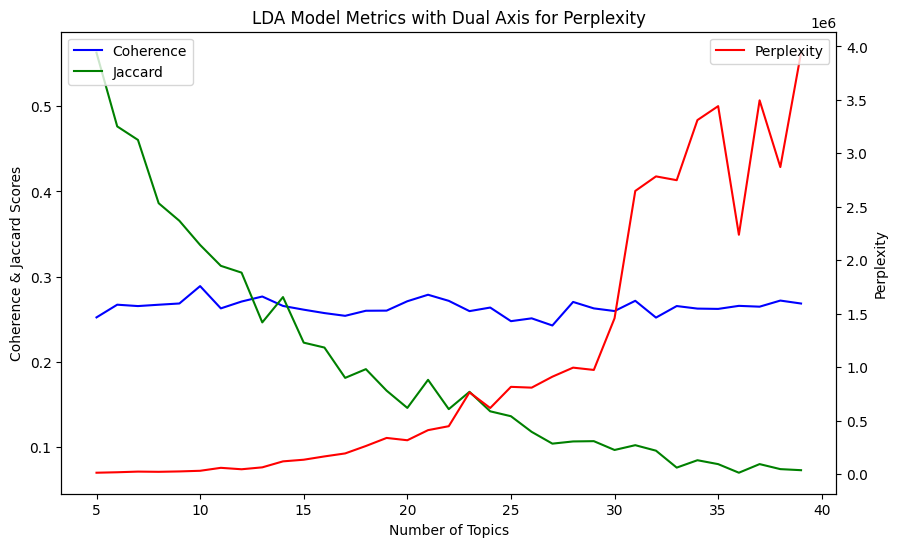

In [ ]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Coherence and Jaccard on the primary y-axis
ax1.plot(results['num_topic'], results['Coherence'], label='Coherence', color='blue')
ax1.plot(results['num_topic'], results['Jaccard'], label='Jaccard', color='green')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence & Jaccard Scores')

# Create a second y-axis for Perplexity
ax2 = ax1.twinx()
ax2.plot(results['num_topic'], results['Perplexity'], label='Perplexity', color='red')
ax2.set_ylabel('Perplexity')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('LDA Model Metrics with Dual Axis for Perplexity')
plt.show()

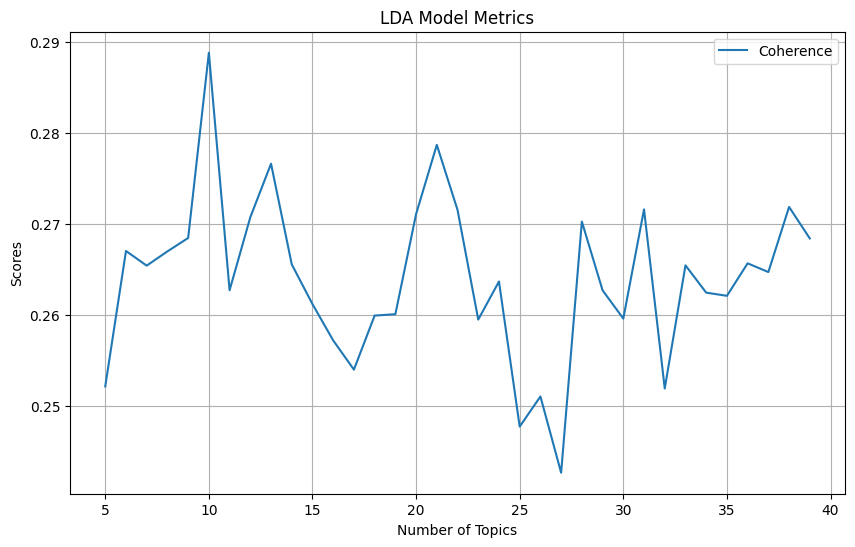

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results['num_topic'], results['Coherence'], label='Coherence')
#plt.plot(results['num_topic'], results['Jaccard'], label='Jaccard')
#plt.plot(results['num_topic'], results['Perplexity'], label='Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Scores')
plt.title('LDA Model Metrics')
plt.grid(True)
plt.legend()
plt.show()



```
coh0 = 0
js0 = 100
ppx0 = 100
num = 1
for topic_num in range (5, 100):
  lda = decomposition.LatentDirichletAllocation (n_components=topic_num, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
  # n_components is the number of topics

  w1 = lda.fit_transform (tf_vectors)
  #h1 = lda.components_

  ppx = lda.perplexity(w1,  sub_sampling=False)

  coh = mean (metric_coherence_gensim(measure='c_v', top_n=30, topic_word_distrib=lda.components_, vocab=np.array([x for x in vectorizer_tf.vocabulary_.keys()]), texts=tok))

  l = len (lda.components_)
  n = 0
  js = 0
  for i in range(0, l-1):
    topic1 = [1 if x>1 else 0 for x in lda.components_[i]]
    for j in range(i+1, l):
      topic2 = [1 if x>1 else 0 for x in lda.components_[j]]
      js += jaccard_score (topic1, topic2)
      n += 1
  js /= n

  if js > js0 and coh < coh0 and ppx > ppx0:
    pass
  else:
    num = topic_num
    js0 = js
    coh0 = coh
    ppx0 = ppx

  print ('num_topic: ', topic_num, 'Coherence: ', coh, 'Jaccard: ', js, 'Perplexity: ', ppx)
#print ('BEST: ', 'num_topic: ', num, 'Coherence: ', coh0, 'Jaccard: ', js0, 'Perplexity: ', ppx0)
```



In [ ]:
#XXXXXXXXXXXXXXXXXXXXXXXXX

# Topic Modeling

In [ ]:
!pip install pyLDAvis==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.1 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

In [ ]:
n_topics = 10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda = decomposition.LatentDirichletAllocation (n_components=n_topics, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
# n_components is the number of topics

w1 = lda.fit_transform (tf_vectors)
h1 = lda.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/lda_patent_therapy_{n_topics}.pk","wb") as f1:
    pickle.dump (lda, f1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle
lda = decomposition.LatentDirichletAllocation (n_components=n_topics, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/lda_patent_therapy_{n_topics}.pk","rb") as f1:
    lda = pickle.load (f1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(lda, tf_vectors, vectorizer_tf, mds='tsne')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


What did I do to make this work?

I installed pyLDAvis, but didn't import it!

I went to usr/local/lib/python3.10/dist-packages/pyLDAvis/sklearn.py
and changed get_feature_names() to get_feature_names_out()

saved it!
Then imported pyLDAvis and pyLDAvis.sklearn

In [ ]:
w1 = lda.transform (tf_vectors)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
w1.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2309, 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
text = []
topic = []
probabilit = []
for i in range(len(idx)):
  text.append (str(data[idx[i]]))
  t = np.argmax (w1[i,:])
  topic.append (t)
  probabilit.append (w1[i,t])
probabilities = pd.DataFrame (data= {'Text':text,'Topic':topic,'Probability':probabilit})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Topic:','Number:')
for i in range(n_topics):
  print('topic',i,'    ',list(probabilities['Topic']).count(i))

Topic: Number:
topic 0      12
topic 1      155
topic 2      354
topic 3      498
topic 4      154
topic 5      46
topic 6      67
topic 7      441
topic 8      406
topic 9      176


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# topic similarity matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## cosine_similarity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


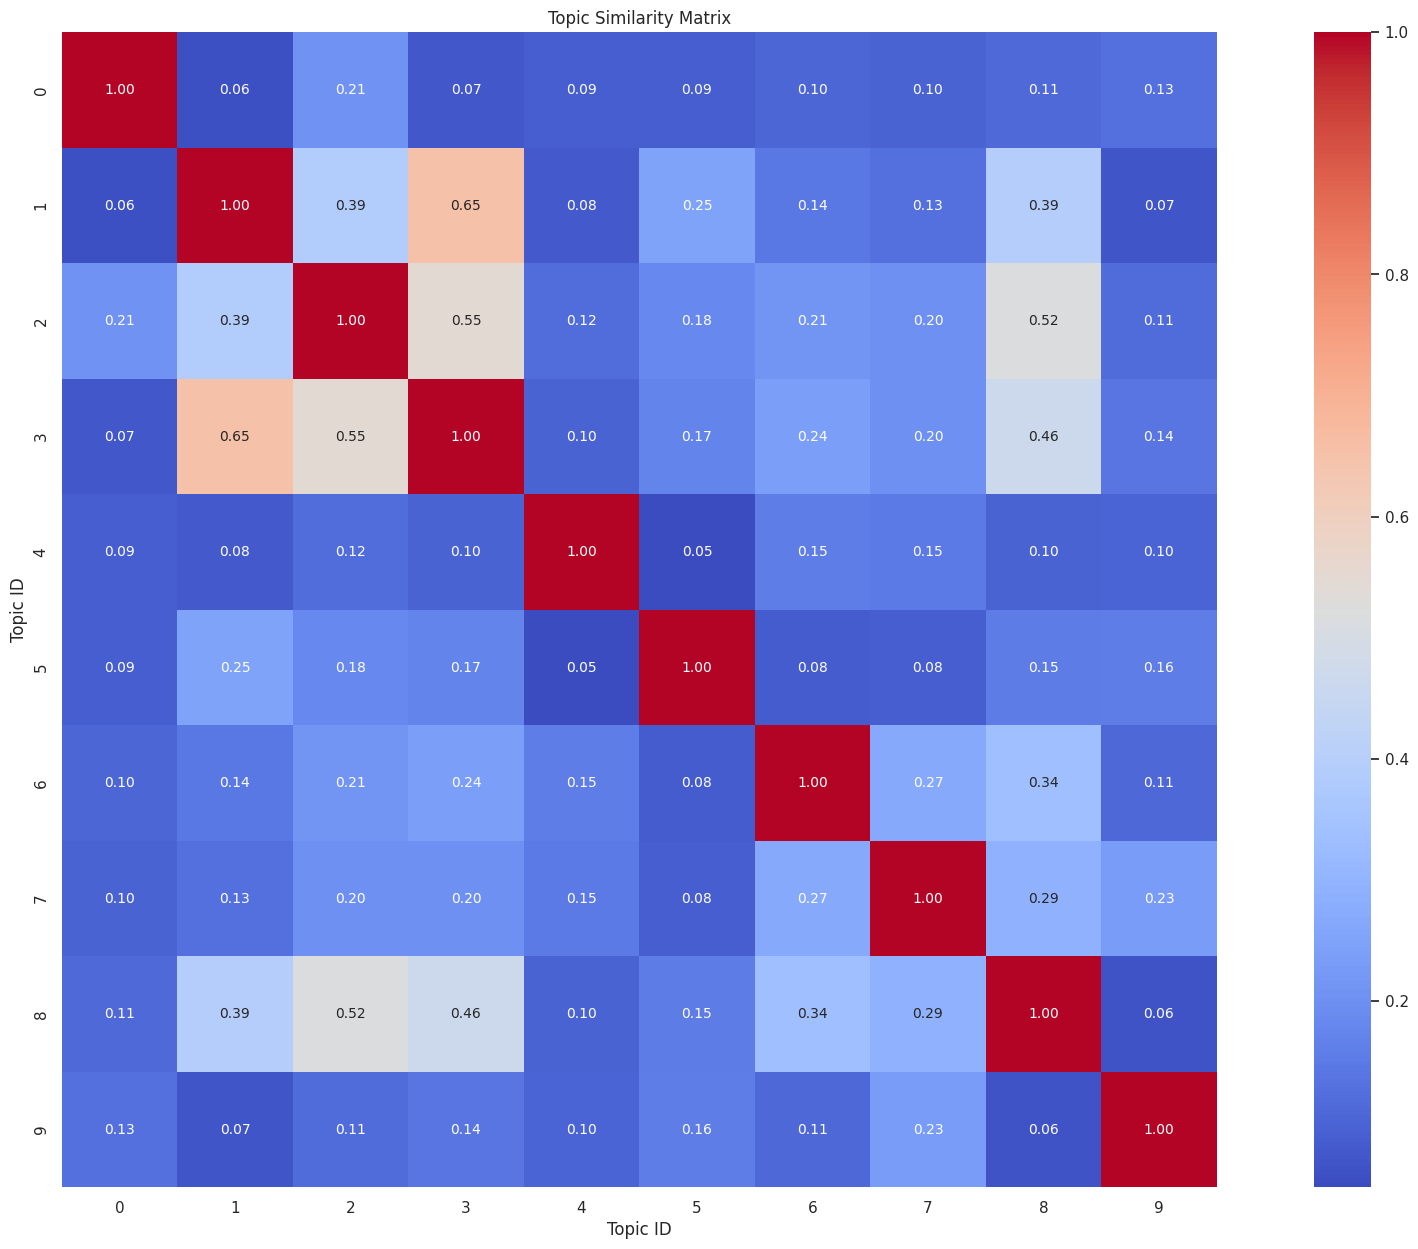

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming lda_model is your trained LDA model
# Normalize the topic-word distribution
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Compute the cosine similarity matrix
topic_similarity_matrix = cosine_similarity(topic_word_distributions)

# Create a heatmap
plt.figure(figsize=(25, 15))
sns.set(font_scale=1)
sns.heatmap(
    topic_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": n_topics},
)
plt.title("Topic Similarity Matrix")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")

# Save the figure
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_similarity_matrix_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


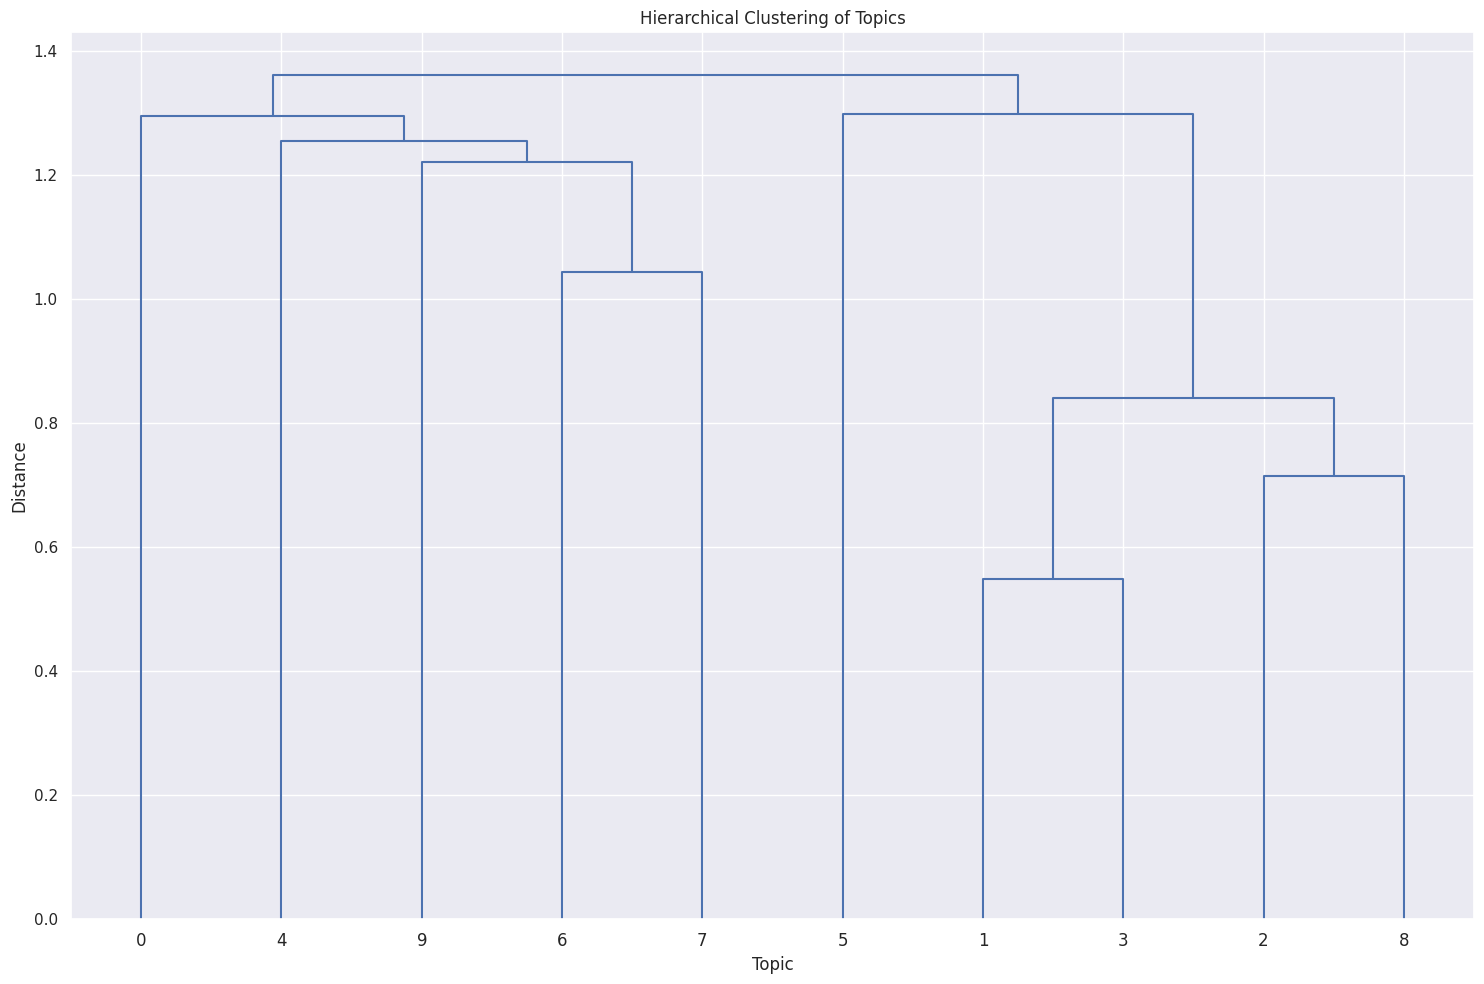

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity

# Assuming lda_model is your trained LDA model
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Compute the cosine similarity matrix
topic_similarity_matrix = cosine_similarity(topic_word_distributions)

# Perform hierarchical clustering
linkage_matrix = linkage(1 - topic_similarity_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, color_threshold=0.5)
plt.title("Hierarchical Clustering of Topics")
plt.xlabel("Topic")
plt.ylabel("Distance")
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_clustering_dendrogram_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## jaccard_similarity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


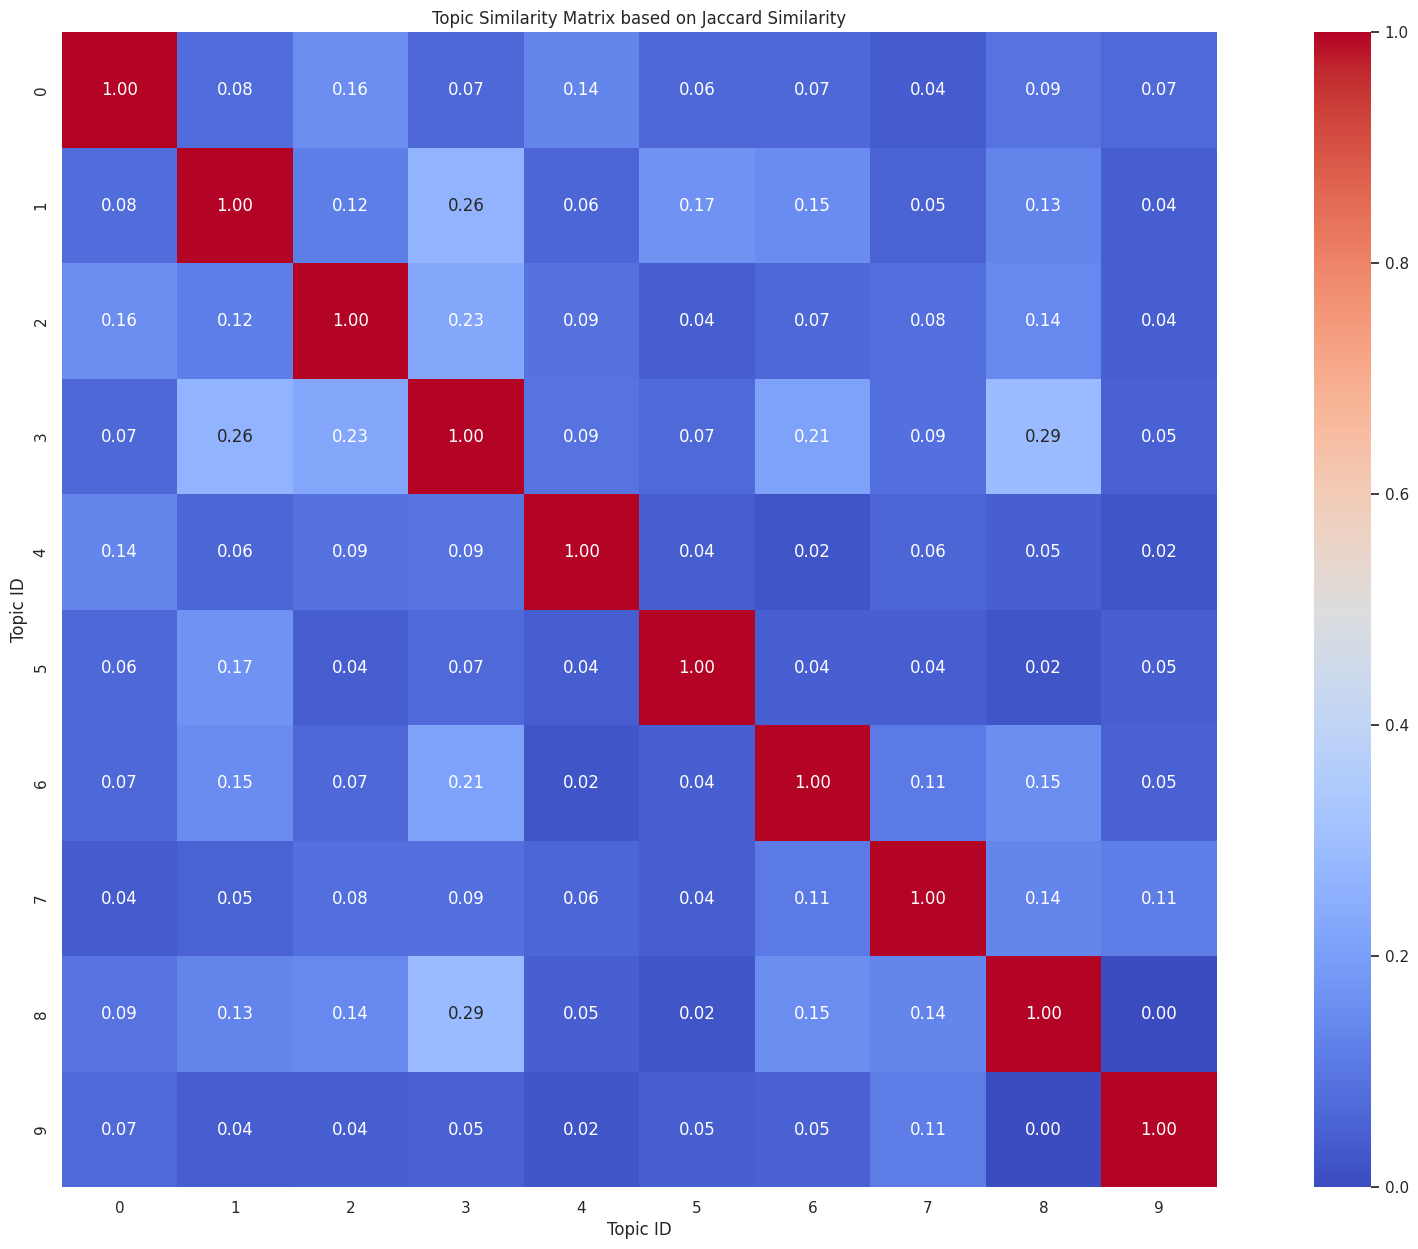

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation

def jaccard_similarity(vector1, vector2, threshold=0.01):
    set1 = set(np.where(vector1 > threshold)[0])
    set2 = set(np.where(vector2 > threshold)[0])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 0
    else:
        return intersection / union


# Assuming lda is your trained LDA model
# Normalize the topic-word distribution
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Number of topics
n_topics = lda.components_.shape[0]

# Create Jaccard Similarity matrix
jaccard_similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        jaccard_similarity_matrix[i, j] = jaccard_similarity(topic_word_distributions[i, :], topic_word_distributions[j, :], threshold=0.01)


# Plot Heatmap
plt.figure(figsize=(25, 15))
sns.set(font_scale=1)
sns.heatmap(
    jaccard_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 12}
)
plt.title("Topic Similarity Matrix based on Jaccard Similarity")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")

# Save the figure
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_similarity_matrix_jaccard_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-1d34c3b7ddb3>:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - jaccard_similarity_matrix, method="average")


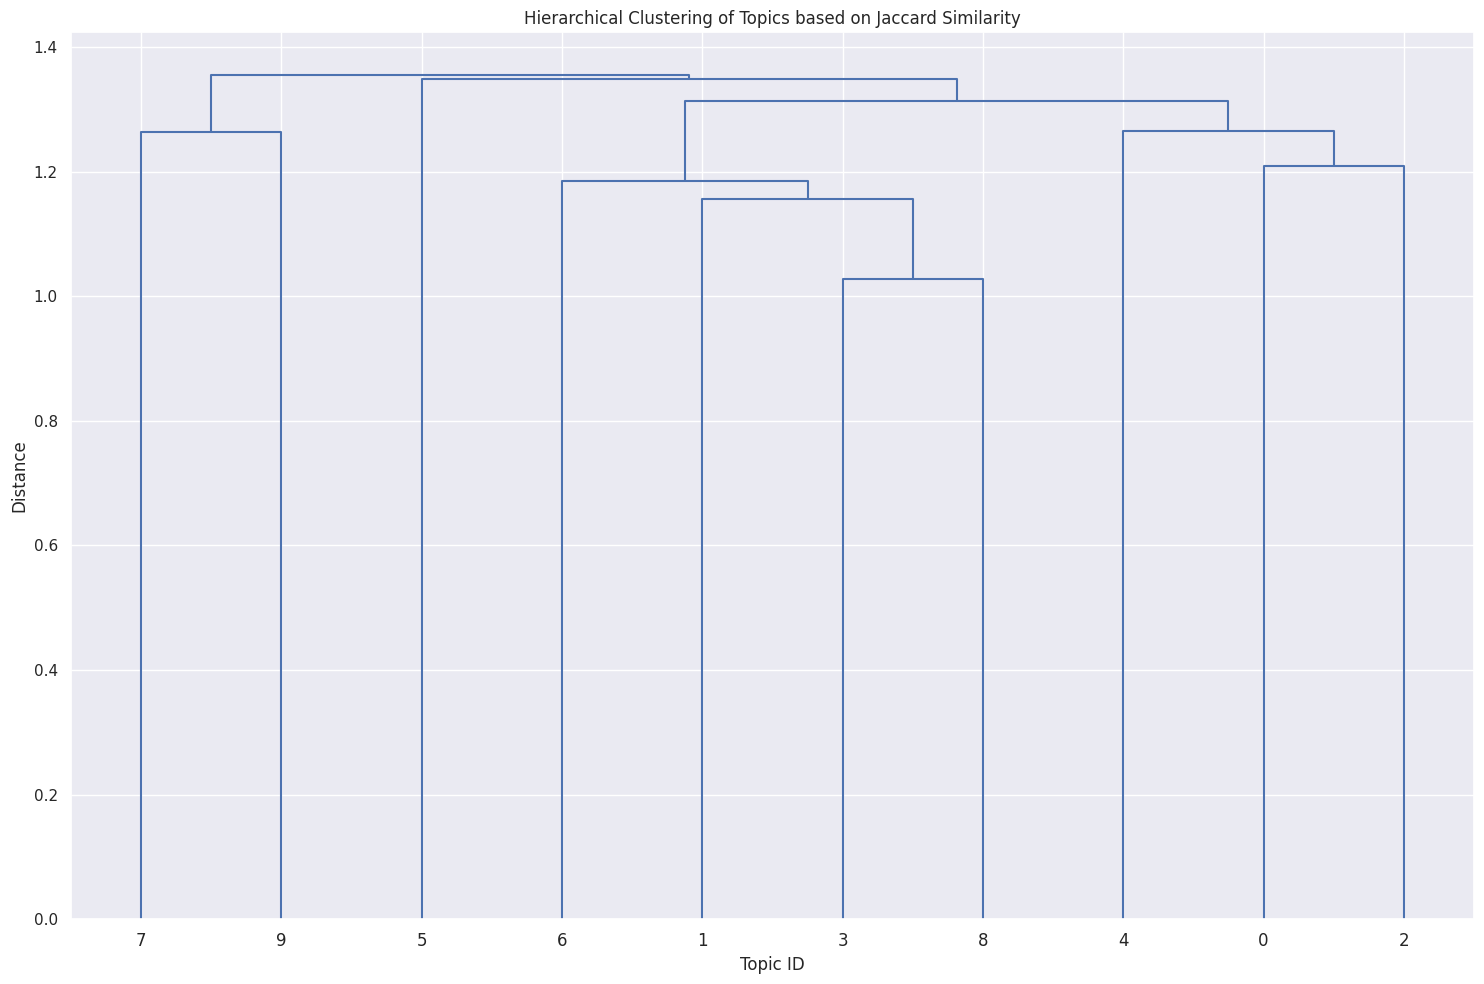

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import LatentDirichletAllocation

# Define Jaccard Similarity function
def jaccard_similarity(vector1, vector2, threshold=0.01):
    set1 = set(np.where(vector1 > threshold)[0])
    set2 = set(np.where(vector2 > threshold)[0])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 0
    else:
        return intersection / union


# Assuming lda is your trained LDA model
n_topics = lda.components_.shape[0]
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Create Jaccard Similarity matrix
jaccard_similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        jaccard_similarity_matrix[i, j] = jaccard_similarity(topic_word_distributions[i, :], topic_word_distributions[j, :], threshold=0.01)

# Perform hierarchical clustering
linkage_matrix = linkage(1 - jaccard_similarity_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, color_threshold=0.5)
plt.title("Hierarchical Clustering of Topics based on Jaccard Similarity")
plt.xlabel("Topic ID")
plt.ylabel("Distance")
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_clustering_dendrogram_jaccard_patent_therapy_23102023_{n_topics}.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get_top_keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_top_keywords(lda_model, vectorizer, n_words=50):
    terms = vectorizer.get_feature_names_out()
    topic_keywords = []

    for topic_idx, topic in enumerate(lda.components_):
        top_keywords_idx = topic.argsort()[::-1][:n_words]
        top_keywords = [(terms[i], topic[i]) for i in top_keywords_idx]
        topic_keywords.append(top_keywords)

    return topic_keywords

top_keywords = get_top_keywords(lda, vectorizer_tf, n_words=50)

# To display the topics with their keywords and scores
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/top_keywords_patent_therapy_23102023_{n_topics}.txt", "w") as f:
    for idx, keywords in enumerate(top_keywords):
        f.write(f"Topic {idx}:\n")
        print(f"Topic {idx}:")
        for word, score in keywords:
            f.write(f"{word}, ")
            print(f"{word}", end=", ")
        f.write("\n\n")
        print("\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0:
compound, group, formula, acid, product, preparation, amino, agent, contain, base, material, obtain, correspond, describe, process, prepare, treat, form, culture, activity, free, phage, produce, presence, fermentation, antibiotic, reaction, active, sequence, cell, remove, treatment, production, capable, low, exhibit, temperature, chain, bacteria, step, synthetic, synthesize, solve, chemical, residue, conventional, therapeutic, separate, extract, structure, 

Topic 1:
bacteriophage, composition, antibiotic, salmonella, coli, escherichia, feed, invention, disease, present, bacteria, infectious, specific, prevent, treat, resistant, additive, antibacterial, comprise, disinfectant, relate, problem, host, pathogenic, method, food, animal, activity, agent, infect, kill, human, range, prevention, field, excellent, plant, solve, treatment, samethe, addition, wide, include, resistance, due, high, ability, chemical, step, number, 

Topic 2:
bacteriophage, method, preparation, strain, tre

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Emergent topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cm

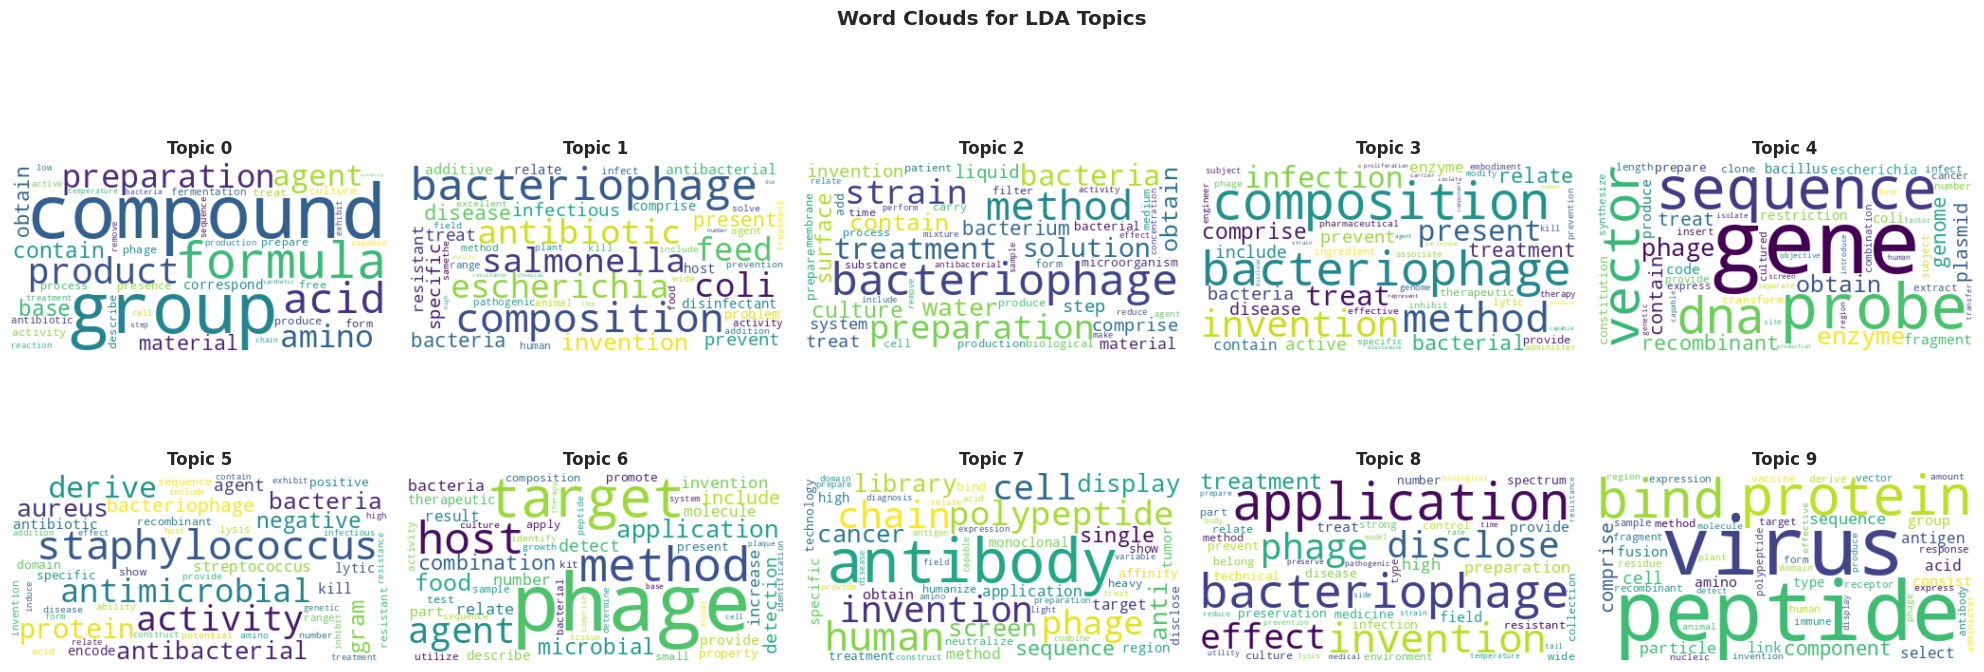

In [ ]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

# Word Clouds for topics
def plot_wordcloud(lda, topic_id, ax, n_words=50):
    terms = vectorizer_tf.get_feature_names_out()
    word_probs = {terms[i]: prob for i, prob in enumerate(lda.components_[topic_id])}
    wc = WordCloud(background_color='white', max_words=n_words).generate_from_frequencies(word_probs)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {topic_id}", fontweight='bold')  # Bold title for each subplot

# Assuming n_topics to be the number of topics you've chosen
n_topics = n_topics  # Make sure this matches the number of topics in lda_model

# Calculate the number of rows needed
n_rows = int(np.ceil(n_topics / 5))

fig, axes = plt.subplots(n_rows, 5, figsize=(20, 4 * n_rows))

# Flatten the array and truncate it to match the number of topics
axes_flat = axes.flatten()[:n_topics]

for ax, topic_id in zip(axes_flat, range(n_topics)):
    plot_wordcloud(lda, topic_id, ax)

# Remove extra subplots
for idx in range(n_topics, len(axes.flatten())):
    fig.delaxes(axes.flatten()[idx])

plt.suptitle("Word Clouds for LDA Topics", fontweight='bold')  # Bold main title
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/wordclouds_patent_therapy_23102023_{n_topics}.png', dpi=600)  # Use raw string for path
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Attach Discovered Topic Labels to Original scholar publications

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_topics = lda.transform(tf_vectors)
final_topics.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2309, 10)

In [ ]:
df_filtered["Topic N°"] = final_topics.argmax(axis=1)
df_filtered.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Cleaned_Text,Topic N°
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
069-390-611-717-343,2003,1,RU,C2,RU 2214829 C2,2003-10-27,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED,method tuberculosis phagotherapyfield: medicin...,2
114-759-028-882-736,2016,2,JP,A,JP 2016104011 A,2016-06-09,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE,"antibacterial phages, phage peptides methods t...",3
094-982-928-461-863,2015,3,AU,A1,AU 2015/255318 A1,2015-12-03,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE,"antibacterial phage, phage peptides methods th...",3
112-018-476-081-94X,2017,5,AU,A1,AU 2017/204331 A1,2017-07-13,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED,"antibacterial phage, phage peptides methods th...",3
091-234-230-295-135,2020,6,CN,A,CN 110691603 A,2020-01-14,CN 201780084644 A,2017-12-04,US 201662430113 P;;PT 2017050028 W,2016-12-05,BACTERIOPHAGE COMPOSITIONS COMPRISING RESPIRAT...,The present invention is directed to the field...,TECHNOPHAGE INVESTIG E DESENVOLVIMENTO EM BIOT...,CORTE-REAL SOFIA VALKER;;COSTA GARCIA MIGUEL A...,NaN,https://lens.org/091-234-230-295-135,Patent Application,no,2,0,17,17,0,A61K35/76;;C12N2795/00011;;C12N2795/00021;;C12...,A61K35/76;;A01N63/40;;A61P31/04;;C12N7/00;;C12...,NaN,2,2,012-547-311-502-556;;041-469-997-710-624,10.1128/jb.188.3.1184-1187.2006;;16428425;;pmc...,"TONY KWAN ET AL: ""Comparative genomic analysis...",PENDING,bacteriophage compositions comprising respirat...,3


In [ ]:
# Save data to CSV and Pickle formats
df_filtered.to_csv(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_probability_patent_therapy_23102023_{n_topics}.csv', index=False)
df_filtered.to_pickle(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_probability_patent_therapy_23102023_{n_topics}.pkl')

df_filtered.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Cleaned_Text,Topic N°
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
069-390-611-717-343,2003,1,RU,C2,RU 2214829 C2,2003-10-27,RU 2001129920 A,2001-11-05,RU 2001129920 A,2001-11-05,METHOD FOR TUBERCULOSIS PHAGOTHERAPY,"FIELD: medicine, phthisiology. SUBSTANCE: meth...",NOVOSIB NII T;;UBERKULEZA,KURUNOV JU N;;KURUNOVA N N;;SHATALOVA N D,NaN,https://lens.org/069-390-611-717-343,Granted Patent,no,0,4,1,1,0,NaN,A61K35/76;;A61P31/06,NaN,0,0,NaN,NaN,NaN,EXPIRED,method tuberculosis phagotherapyfield: medicin...,2
114-759-028-882-736,2016,2,JP,A,JP 2016104011 A,2016-06-09,JP 2015243657 A,2015-12-14,US 38401510 P,2010-09-17,"ANTIBACTERIAL PHAGES, PHAGE PEPTIDES AND USE M...",PROBLEM TO BE SOLVED: To provide novel bacteri...,TECNIFAR-INDUSTRIA TECNICA FARM S A;;TECHNOPHA...,MIGUEL ANGELO DA COSTA GARCIA;;CARLOS JORGE SO...,NaN,https://lens.org/114-759-028-882-736,Patent Application,no,1,1,48,48,1300,C12N2795/00032;;A61K31/505;;A61K31/7056;;A61K3...,C12N7/00;;A61K35/76;;A61P31/04;;C12N15/09,NaN,0,0,NaN,NaN,NaN,ACTIVE,"antibacterial phages, phage peptides methods t...",3
094-982-928-461-863,2015,3,AU,A1,AU 2015/255318 A1,2015-12-03,AU 2015/255318 A,2015-11-13,AU 2015/255318 A;;AU 2010/211456 A;;US 2183450...,2009-02-06,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECNIFAR INDÚSTRIA TÉCNICA FARMACÉUTICA S A;;T...,DA COSTA GARCIA MIGUEL ÂNGELO;;SOUSA DE SÃO JO...,"TECHNOPHAGE, INVESTIGACAO E DESENVOLVIMENTO EM...",https://lens.org/094-982-928-461-863,Patent Application,no,0,0,3,45,0,NaN,A61K35/76;;C12N9/14;;G01N33/569,NaN,0,0,NaN,NaN,NaN,ACTIVE,"antibacterial phage, phage peptides methods th...",3
112-018-476-081-94X,2017,5,AU,A1,AU 2017/204331 A1,2017-07-13,AU 2017/204331 A,2017-06-26,AU 2017/204331 A;;AU 2015/255313 A;;AU 2011/30...,2011-09-19,"Antibacterial phage, phage peptides and method...",The present invention is directed to the field...,TECHNOPHAGE INVESTIGACAO E DESENVOLVIMENTO EM ...,DA COSTA GARCIA MIGUEL ANGELO;;SOUSA DE SAO JO...,NaN,https://lens.org/112-018-476-081-94X,Patent Application,no,0,3,1,1,0,Y02A50/30,A61K35/76;;C12N7/00,NaN,0,0,NaN,NaN,NaN,DISCONTINUED,"antibacterial phage, phage peptides methods th...",3
091-234-230-295-135,2020,6,CN,A,CN 110691603 A,2020-01-14,CN 201780084644 A,2017-12-04,US 201662430113 P;;PT 2017050028 W,2016-12-05,BACTERIOPHAGE COMPOSITIONS COMPRISING RESPIRAT...,The present invention is directed to the field...,TECHNOPHAGE INVESTIG E DESENVOLVIMENTO EM BIOT...,CORTE-REAL SOFIA VALKER;;COSTA GARCIA MIGUEL A...,NaN,https://lens.org/091-234-230-295-135,Patent Application,no,2,0,17,17,0,A61K35/76;;C12N2795/00011;;C12N2795/00021;;C12...,A61K35/76;;A01N63/40;;A61P31/04;;C12N7/00;;C12...,NaN,2,2,012-547-311-502-556;;041-469-997-710-624,10.1128/jb.188.3.1184-1187.2006;;16428425;;pmc...,"TONY KWAN ET AL: ""Comparative genomic analysis...",PENDING,bacteriophage compositions comprising respirat...,3


In [ ]:
df_filtered['Topic N°'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    498
7    441
8    406
2    354
9    176
1    155
4    154
6     67
5     46
0     12
Name: Topic N°, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Frequency Counting

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Step 1: Group data by 'Publication Year' and 'topic', then count occurrences
topic_counts_by_year = df_filtered.reset_index().groupby(['Publication Year', 'Topic N°']).size().unstack(fill_value=0)

# Step 2: Calculate the total count of each topic
total_counts = topic_counts_by_year.sum()

# Step 3: Sort columns by total count
sorted_columns = total_counts.sort_values(ascending=False).index
topic_counts_by_year = topic_counts_by_year[sorted_columns]

# Step 4: Add a row with the total count of each topic
topic_counts_by_year.loc['Total'] = total_counts.loc[sorted_columns]

# Save the DataFrame to CSV and pickle files
topic_counts_by_year.to_csv(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_counts_by_year_patent_therapy_23102023_{n_topics}.csv')
topic_counts_by_year.to_pickle(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_counts_by_year_patent_therapy_23102023_{n_topics}.pkl')

# This will give you a DataFrame where each row is a year (plus a 'Total' row at the bottom),
# and each column is the count of documents associated with a topic for that year (and the total count).

# Display the updated DataFrame
topic_counts_by_year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic N°,3,7,8,2,9,1,4,6,5,0
Publication Year,,,,,,,,,,
1957,0,0,0,1,0,0,0,0,0,0
1958,0,0,1,0,0,0,0,0,0,0
1959,0,0,0,1,0,0,0,0,0,0
1960,0,0,0,1,0,0,0,0,0,0
1961,0,0,0,0,1,0,0,0,0,0
1967,0,0,0,2,0,0,0,0,0,0
1969,0,0,0,1,0,0,0,0,0,4
1970,0,0,0,0,0,0,0,0,0,1
1971,0,0,0,2,0,0,0,0,0,0


In [ ]:
topic_counts_by_year.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(59, 10)

In [ ]:
# Evolution Curve for Each Topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


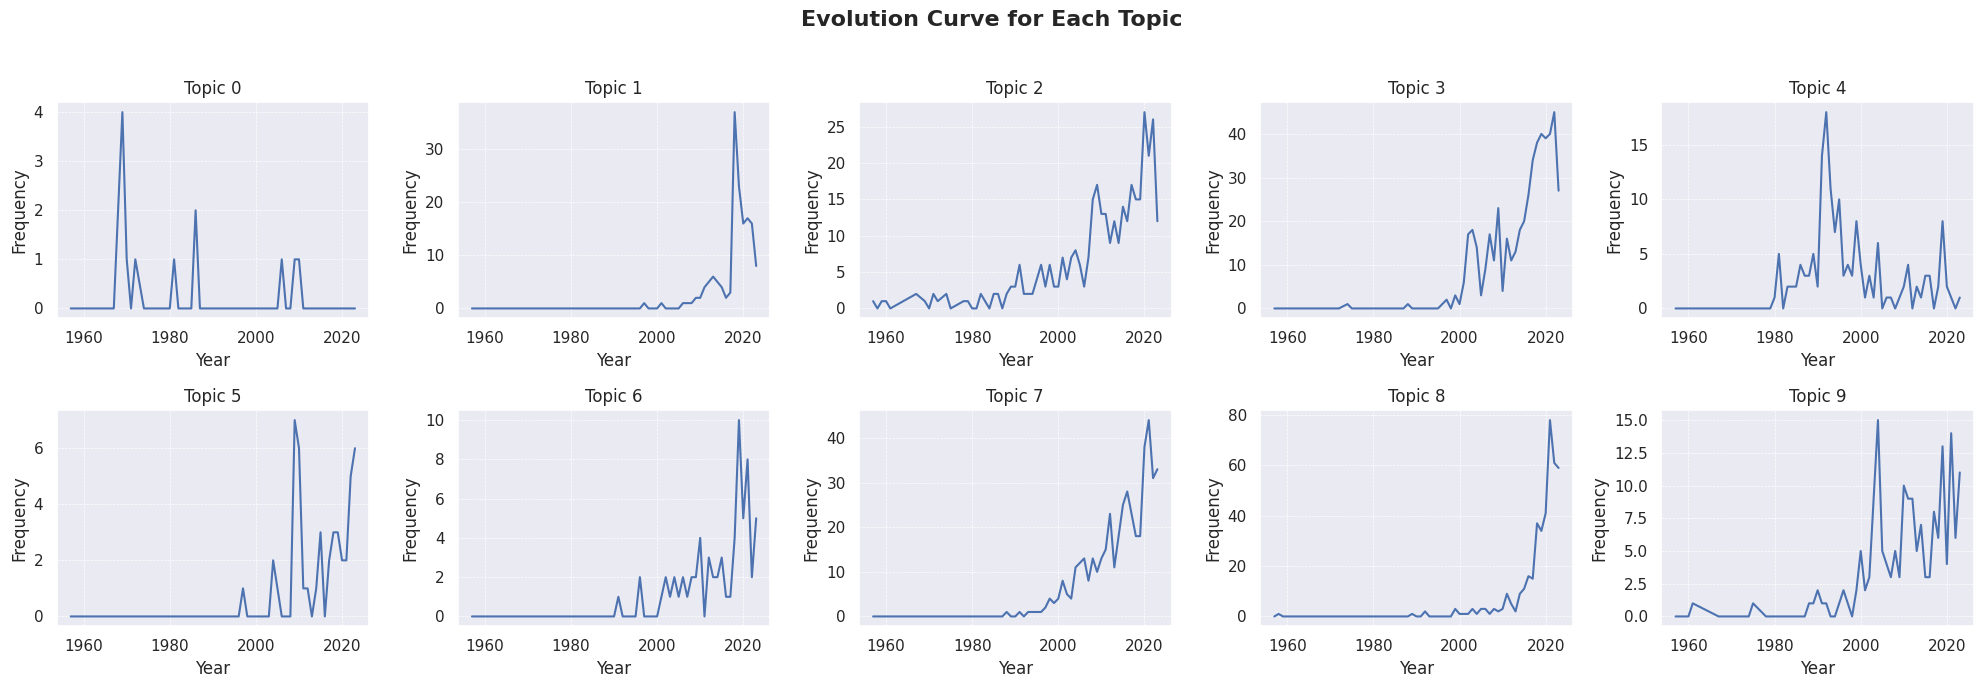

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the DataFrame from the CSV file (assuming it's stored as 'topic_counts_by_year.csv')
# Replace this line with your actual data if it's not in a CSV
#topic_counts_by_year = pd.read_csv('topic_counts_by_year.csv', index_col='Publication Year')

# Remove the 'Total' row if it exists
if 'Total' in topic_counts_by_year.index:
    topic_counts_by_year = topic_counts_by_year.drop(index=['Total'])

# Sort columns by topic name
topic_counts_by_year = topic_counts_by_year.sort_index(axis=1)

# Define the number of topics (make sure this matches your data)
n_topics = len(topic_counts_by_year.columns)

# Calculate the number of rows needed for subplots
n_rows = (n_topics + 4) // 5  # +4 for rounding up

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, 5, figsize=(20, n_rows * 3.5))

# Flatten the array to easily iterate over it
axes_flat = axes.flatten()

# Loop through each topic and plot its curve on a separate subplot
for i, topic in enumerate(topic_counts_by_year.columns):
    axes_flat[i].plot(
        topic_counts_by_year.index,
        topic_counts_by_year[topic]
    )
    axes_flat[i].set_title(f'Topic {topic}')
    axes_flat[i].set_xlabel('Year')
    axes_flat[i].set_ylabel('Frequency')
    axes_flat[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove extra subplots
for i in range(n_topics, len(axes_flat)):
    fig.delaxes(axes_flat[i])

# Add a main title for the entire figure
fig.suptitle('Evolution Curve for Each Topic', fontsize=16, fontweight='bold')

# Save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the main title
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_evolution_curves_subplot_ordered_patent_therapy_23102023_{n_topics}.png', dpi=600)

# Show the figure
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Temporal Heatmaps: Display how topic proportions change over time.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


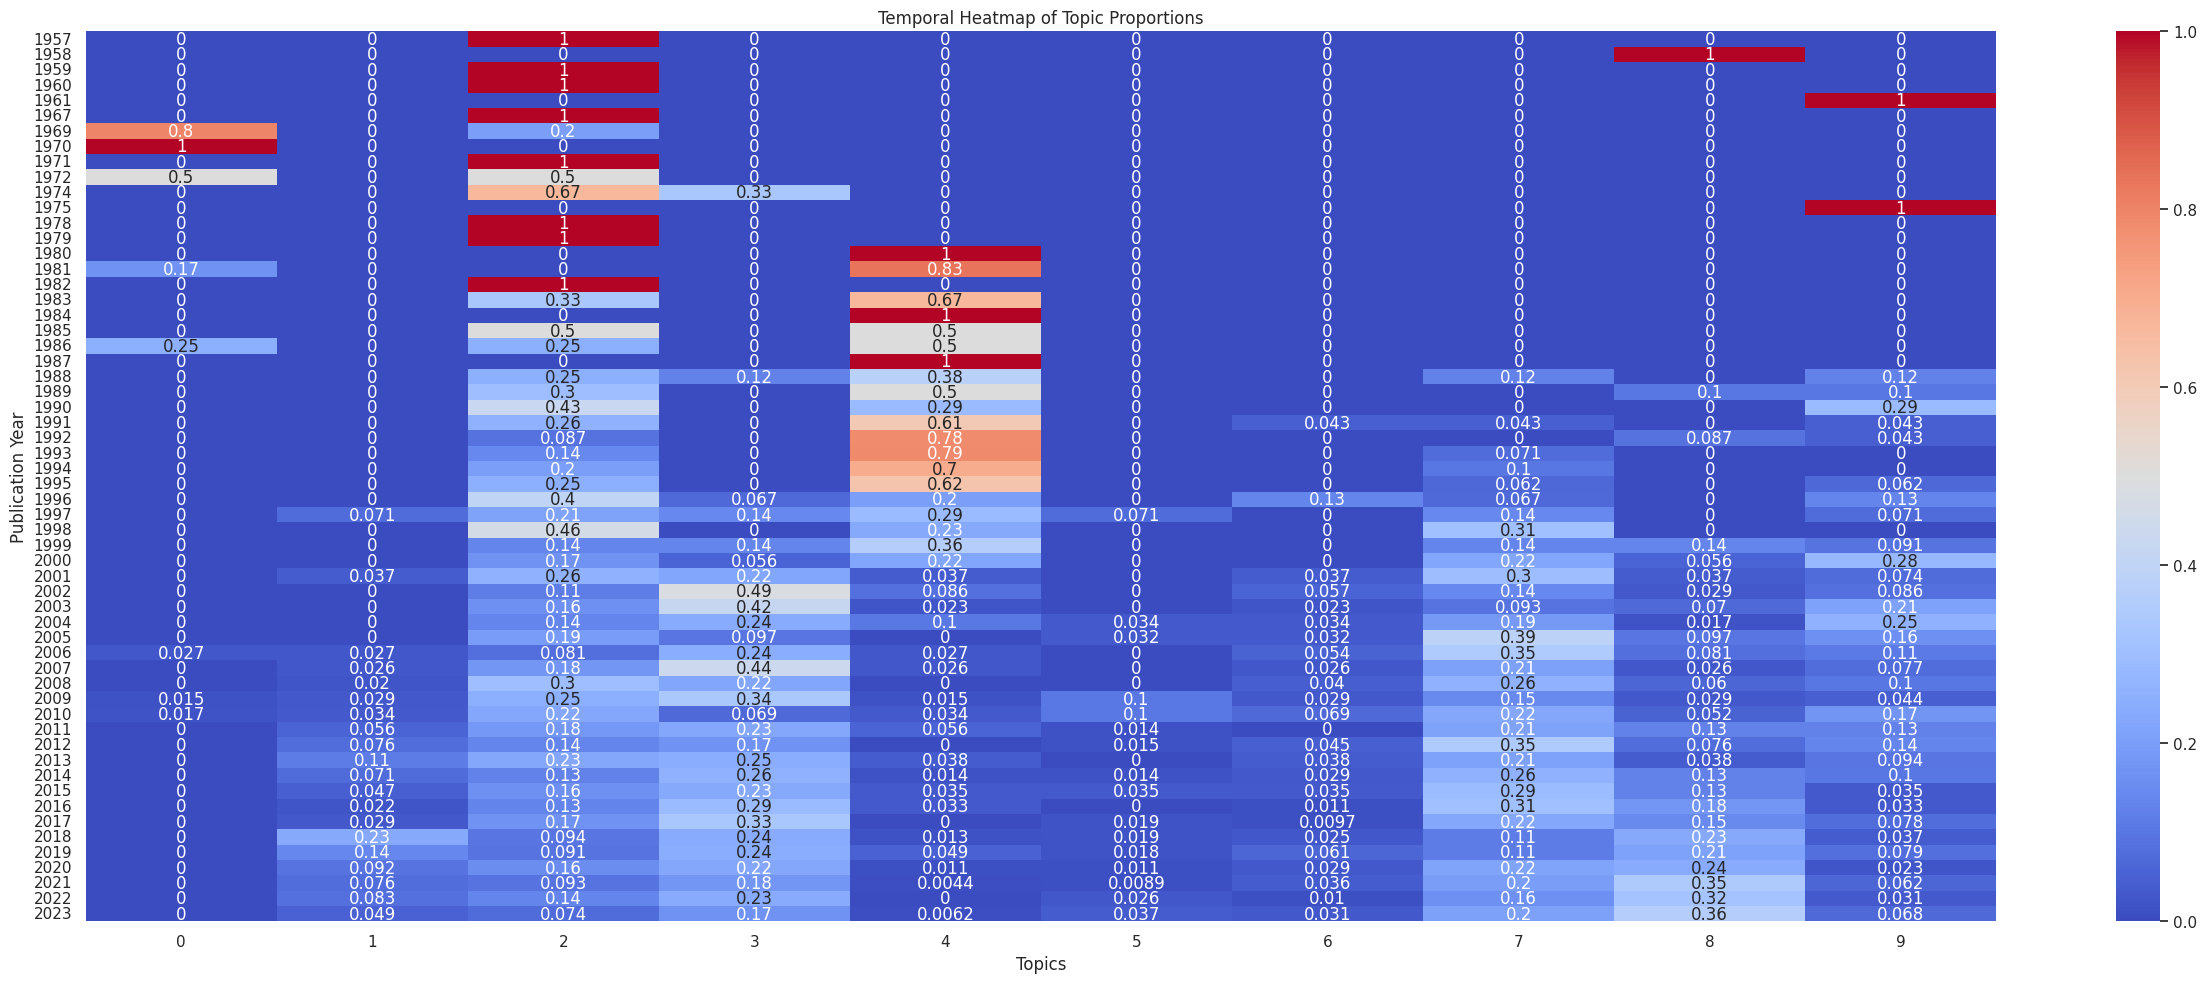

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assume you already have topic_counts_by_year DataFrame

# Remove the 'Total' row if it exists
if 'Total' in topic_counts_by_year.index:
    topic_counts_by_year = topic_counts_by_year.drop(index=['Total'])

# Sort columns by topic name
topic_counts_by_year = topic_counts_by_year.sort_index(axis=1)

# Calculate the total count for each year (row-wise sum)
total_counts_by_year = topic_counts_by_year.sum(axis=1)

# Normalize frequencies to get proportions
proportions_by_year = topic_counts_by_year.divide(total_counts_by_year, axis=0)

# Create the heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(proportions_by_year.fillna(0), annot=True, cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True)

# Add labels and title
plt.title('Temporal Heatmap of Topic Proportions')
plt.xlabel('Topics')
plt.ylabel('Publication Year')

# Save the figure
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/temporal_heatmap_topic_proportions_patent_therapy_23102023_{n_topics}.png")  # Save the plot to a PNG file

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
